# How to work with AρρEEARS Cloud Optimized GeoTIFF (COG) outputs

## Summary  

This tutorial demonstrates how to access AρρEEARS Cloud Optimized GeoTIFF (COG) outputs in AWS. NASA's Application for Extracting and Exploring Analysis Ready Samples ([AρρEEARS](https://appeears.earthdatacloud.nasa.gov/)) is deployed in NASA's Earthdata Cloud space located in **AWS us-west 2**. This enables the user working from cloud instances deployed in **AWS us-west 2** to access outputs directly from an AWS S3 bucket. In this tutorial, we will walk through the process of submitting an area sample and accessing a Cloud Optimized GeoTIFF (COG) outputs from AppEEARS.

This tutorial highlights the Dixie Fire, the second-largest fire in California history. According to [CalFire](https://www.fire.ca.gov/incidents/2021/7/13/dixie-fire/), the fire has started on July 13, 2021 and burned more than 963,276 acres. On August 18, the Dixie Fire merged with the Morgan Fire, which had been started by lightning August 12, close to Lassen National Park. The fire was one hundred percent contained by October 2021.    

## Requirements  

- Earthdata Login Authentication is required to uses the AρρEEARS API and to access AρρEEARS outputs directly.  

## Learning Objectives  

- Learn how to access AρρEEARS Cloud Optimized GeoTIFF (COG) outputs


## Tutorial Outline 

1. Setting Up  
2. Submit an area request in AppEEARS  
3. Extract the Direct S3 links  
4. Create a boto3 Refreshable Session  
5. Single COG File In-Region Direct S3 Access   
6. Multiple COG File In-Region Direct S3 Access  
7. Explore the EVI Time Series   


## 1. Set up

Import the required packages.

In [33]:
import requests
import earthaccess
import getpass, pprint, time, os, cgi, json
import geopandas 
#import numpy
import datetime
import os
#import io
import json
#from urllib import parse
from netrc import netrc
#from uuid import uuid4
import time
#from pathlib import Path
from datetime import datetime, timezone
#from botocore.client import Config
import rioxarray
import xarray
import hvplot.xarray
import holoviews
import geoviews
import rasterio 
from rasterio.plot import show
#from rasterio.session import AWSSession
#import s3fs
import pandas
import warnings
#import sys
#sys.path.append('../modules/')
#import aws_session
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from IPython.display import display
import folium
from folium import plugins
import branca.colormap as cm
from matplotlib import colors as colors

To successfully run this tutorial, it is required to create a **.netrc** file in your home directory. The function `_validate_netrc` defined in `aws_session` checks if a properly formatted netrc file exists in your home directory. If the netrc file does not exist, it will prompt you for your Earthdata Login username and password and will create a netrc file. Please see the **Prerequisites** section in [**README.md**](../README.md). 

In [2]:
earthaccess.login(persist=True)

In [3]:
roi = geopandas.read_file('data/co_agriculture.geojson')
roi

,geometry
0,"POLYGON ((-105.27352 40.76956, -105.27352 39.9..."


In [4]:
x_center = roi.centroid.x
y_center = roi.centroid.y

## 2. Submit an area request in AρρEEARS  
In this step, we are going to submit an area request with GeoTIFF as an output format. You can also submit this request using [AρρEEARS Graphic User Interface (GUI)](https://appeears.earthdatacloud.nasa.gov/task/area) and upload the JSON file provided in the repository (AppEEARS-Data-Resources/Data/Dixie-Fire-request.json). If you have your completed request, save your `task_id` to a variable, skip this step, and move to the next step of tutorial.  

Assign the AρρEEARS API endpoint to a variable. 

In [5]:
appeears_API_endpoint = 'https://appeears.earthdatacloud.nasa.gov/api/'

A **Bearer Token** is needed to submit requests to the AρρEEARS API. To generated a token, a `POST` request containing Earthdata Login credentials stored in the **.netrc** file is submitted to the [`login`](https://appeears.earthdatacloud.nasa.gov/api/#authentication) service. 

In [6]:
urs = 'urs.earthdata.nasa.gov'
token_response = requests.post(f'{appeears_API_endpoint}login', auth = (netrc().authenticators(urs)[0],netrc().authenticators(urs)[2])).json() # Insert API URL, call login service, provide credentials & return json 
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request

Next, compile a JSON object with the request parameters. The Dixie fire started on July 13, 2021, however we're going to extended the search query to include two years to see the time series. A GeoJSON of Region of Interest(ROI) including Lassen National Park region, CA can be downloaded from the repository. For this tutorial, we are requesting the `_500m_16_days_EVI` layer from `MOD13A1.061` to see how Enhanced Vegetation Indices (EVI) varies before and after the fire event. Learn more about the MODIS Vegetation Indices 16-Day Version 6.1 product [here](https://doi.org/10.5067/MODIS/MOD13A1.061). Below we define the AρρEEARS search parameters.  

In [7]:
product_req = requests.get(f'{appeears_API_endpoint}product').json()

In [8]:
product_eco = [x for x in product_req if 'ECOSTRESS' in x['Platform']]    # Get ECOSTRESS product information

In [9]:
layer_req = requests.get(f'{appeears_API_endpoint}product/ECO4ESIALEXI.001').json()

In [10]:
layer_req.keys()    # These are the layer names

dict_keys(['EVAPORATIVE_STRESS_INDEX_ALEXI_ESIdaily', 'EVAPORATIVE_STRESS_INDEX_ALEXI_ESIdailyUncertainty', 'EVAPORATIVE_STRESS_INDEX_ALEXI_QualityFlag'])

In [11]:
task_name = "Colorado_Drought"
task_type = 'area'                  # Type of task, area or point
proj = 'geographic'                 # Set output projection 
outFormat = 'geotiff'               # Set output file format type
startDate = '06-01'            # Start of the date range for which to extract data: MM-DD-YYYY
endDate = '06-30'              # End of the date range for which to extract data: MM-DD-YYYY
yearRange = [2020,2021]
ROI =  geopandas.read_file('data/co_agriculture.geojson').to_json()
prodLayer = [{'layer': 'EVAPORATIVE_STRESS_INDEX_ALEXI_ESIdaily', 'product': 'ECO4ESIALEXI.001'}]

In [12]:
task = {
    'task_type': task_type,
    'task_name': task_name,
    'params': {
         'dates': [
         {
             'startDate': startDate,
             'endDate': endDate,
             'recurring': True,
             'yearRange': yearRange
         }],
         'layers': prodLayer,
         'output': {
                 'format': {
                         'type': outFormat}, 
                         'projection': proj},
         'geo': json.loads(ROI),
    }
}

Next, submit the AρρEEARS request using `post` function from `requests` library.

In [ ]:
task_response = requests.post(f'{appeears_API_endpoint}task', json=task, headers=head).json()    # Post json to the API task service, return response as json
task_response                                                                                    # Print task response

The `task_id` will be needed to get status information about the request and to later find the AρρEEARS outputs for the request. We will save the `task_id` to a variable and wait until our request is processed and complete. 

In [ ]:
task_id = task_response['task_id']
task_id

In [ ]:
# Ping API until request is complete, then continue to Section 3
while requests.get(f'{appeears_API_endpoint}task/{task_id}', headers=head).json()['status'] != 'done':
    print(requests.get(f'{appeears_API_endpoint}task/{task_id}', headers=head).json()['status'])
    time.sleep(60)
print(requests.get(f'{appeears_API_endpoint}task/{task_id}', headers=head).json()['status'])

## 3. Extract the Direct S3 links

Once our outputs are ready, we can get the bundle information for the files included in the outputs. If you submitted your request using AρρEEARS GUI, assign your sample's `task_id` to the variable `task_id` below. 

In [13]:
task_id = 'fdd28cde-de2b-40b4-b3f9-edf33f585649'

`requests.get` is used to get information about our bundle. The bundle information includes `s3_url` in addition to the other information such as output `file_name`, `file_id`, and `file_type`.  

Each output file can be downloaded using the `file_id` (see section 4 in [AppEEARS_API_Area.ipynb](AppEEARS_API_Area.ipynb). Since AρρEEARS outputs are stored in an S3 bucket, outputs can also be accessed using `S3_url` if you are working from an cloud instance in **AWS us-west-2**. 

In [18]:
bundle = requests.get(f'{appeears_API_endpoint}bundle/{task_id}', headers=head).json()  # Call API and return bundle contents for the task_id as json
#bundle

In [15]:
files = {x['file_id']:x['file_name'] for x in bundle['files'] if 'ESIdaily' in x['file_name'] and '.tif' in x['file_name']}
files

{'d843e731-de81-4544-a59d-abfeb837874c': 'ECO4ESIALEXI.001_2020153_to_2021181/ECO4ESIALEXI.001_EVAPORATIVE_STRESS_INDEX_ALEXI_ESIdaily_doy2020156200850_aid0001.tif',
 '7199fab7-96e0-4059-b3e4-03264638c617': 'ECO4ESIALEXI.001_2020153_to_2021181/ECO4ESIALEXI.001_EVAPORATIVE_STRESS_INDEX_ALEXI_ESIdaily_doy2020156200942_aid0001.tif',
 'fdcde1e0-15f4-403b-95cc-3c7fe928947f': 'ECO4ESIALEXI.001_2020153_to_2021181/ECO4ESIALEXI.001_EVAPORATIVE_STRESS_INDEX_ALEXI_ESIdaily_doy2020160183417_aid0001.tif',
 '521baf8f-fe37-4942-bbec-448532fee146': 'ECO4ESIALEXI.001_2020153_to_2021181/ECO4ESIALEXI.001_EVAPORATIVE_STRESS_INDEX_ALEXI_ESIdaily_doy2020160183509_aid0001.tif',
 '7e14ba01-7a05-4158-a3c5-3136d997445b': 'ECO4ESIALEXI.001_2020153_to_2021181/ECO4ESIALEXI.001_EVAPORATIVE_STRESS_INDEX_ALEXI_ESIdaily_doy2020161010357_aid0001.tif',
 '0b15d92f-87f3-444e-891d-245abc2c7498': 'ECO4ESIALEXI.001_2020153_to_2021181/ECO4ESIALEXI.001_EVAPORATIVE_STRESS_INDEX_ALEXI_ESIdaily_doy2020161010449_aid0001.tif',
 '2b

Download files to data directory

In [23]:
if not os.path.exists('data'):
    os.makedirs('data')

In [24]:
for f in files:
    dl = requests.get(f'{appeears_API_endpoint}bundle/{task_id}/{f}', headers=head, stream=True, allow_redirects = 'True')                                # Get a stream to the bundle file
    if files[f].endswith('.tif'):
        filename = files[f].split('/')[1]
    else:
        filename = files[f] 
    filepath = os.path.join('data', filename)                                                       # Create output file path
    with open(filepath, 'wb') as f:                                                                  # Write file to dest dir
        for data in dl.iter_content(chunk_size=8192): f.write(data) 

In [25]:
file_list_2020 = [x for x in os.listdir('data') if 'ECO4ESIALEXI' in x and 'doy2020' in x]
file_list_2020.sort()
#file_list_2020

In [26]:
file_list_2021 = [x for x in os.listdir('data') if 'ECO4ESIALEXI' in x and 'doy2021' in x]
file_list_2021.sort()
#file_list_2021

In [27]:
infile = rasterio.open(f'data/{file_list_2020[2]}')
infile.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 9999.0,
 'width': 1372,
 'height': 1222,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0006308593211379248, 0.0, -105.27397944306747,
        0.0, -0.0006308593211379248, 40.770066677687716)}

In [28]:
data = infile.read(1)
data

array([[5.9932488e-01, 6.1588973e-01, 6.3945675e-01, ..., 9.9990000e+03,
        9.9990000e+03, 9.9990000e+03],
       [5.9497851e-01, 6.1588973e-01, 6.9715333e-01, ..., 9.9990000e+03,
        9.9990000e+03, 9.9990000e+03],
       [6.3289875e-01, 6.6715187e-01, 6.9715333e-01, ..., 9.9990000e+03,
        9.9990000e+03, 9.9990000e+03],
       ...,
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 7.5461036e-01,
        7.4298865e-01, 7.5098956e-01],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 7.5461036e-01,
        8.1639028e-01, 7.8545958e-01],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 7.6846141e-01,
        8.1263268e-01, 7.8157365e-01]], dtype=float32)

In [29]:
nodata = infile.nodatavals[0]
type(nodata)

float

In [30]:
data_m = np.where(data==nodata, np.nan, data)
data_m

array([[0.5993249 , 0.6158897 , 0.63945675, ...,        nan,        nan,
               nan],
       [0.5949785 , 0.6158897 , 0.69715333, ...,        nan,        nan,
               nan],
       [0.63289875, 0.66715187, 0.69715333, ...,        nan,        nan,
               nan],
       ...,
       [1.        , 1.        , 1.        , ..., 0.75461036, 0.74298865,
        0.75098956],
       [1.        , 1.        , 1.        , ..., 0.75461036, 0.8163903 ,
        0.7854596 ],
       [1.        , 1.        , 1.        , ..., 0.7684614 , 0.8126327 ,
        0.78157365]], dtype=float32)

In [31]:
norm_data = (data_m - np.nanmin(data_m)) / (np.nanmax(data_m) - np.nanmin(data_m))    

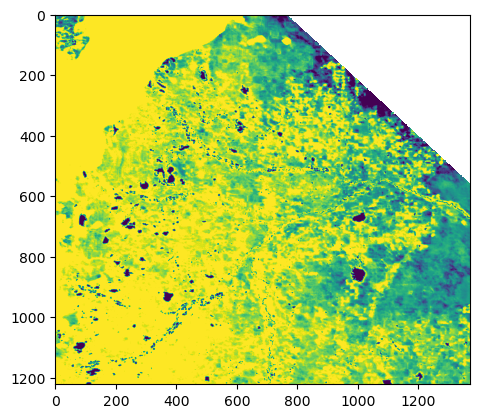

In [32]:
plt.imshow(norm_data)

In [34]:
colormap = ['blue', 'green', 'yellow', 'red']
linear = cm.LinearColormap(['blue', 'green', 'yellow', 'red'], vmin=0, vmax=1)
linear

In [35]:
#https://github.com/royalosyin/Overlay-GeoTiff-Raster-with-nodata-On-Interactive-Map/blob/master/scripts/ex2-Overlay%20Raster%20with%20nodata%20on%20Interactive%20Map%20with%20Folium.ipynb

vmin = 0
vmax = 1

#colormap = cm.linear.RdBu_11.scale(vmin, vmax)
colormap = cm.linear.magma.scale(vmin, vmax)

def mapvalue2color(value, cmap): 
    """
    Map a pixel value of image to a color in the rgba format. 
    As a special case, nans will be mapped totally transparent.
    
    Inputs
        -- value - pixel value of image, could be np.nan
        -- cmap - a linear colormap from branca.colormap.linear
    Output
        -- a color value in the rgba format (r, g, b, a)    
    """
    if np.isnan(value):
        return (1, 0, 0, 0)
    else:
        return colors.to_rgba(cmap(value), 0.1)

In [36]:
# f = folium.Figure(width=1000, height=500)
# m = folium.Map(location=[y_center, x_center], zoom_start=10).add_to(f)
# folium.raster_layers.ImageOverlay(image=norm_data, bounds=[[infile.bounds[1], infile.bounds[0]],[infile.bounds[3], infile.bounds[2]]], colormap= lambda value: mapvalue2color(value, colormap), opacity=0.7).add_to(m)
# display(m)

In [37]:
# def colorize(array, nodata, cmap='viridis'):
#     data = np.where(array==nodata, np.nan, array)
#     norm_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))    
#     cm = plt.cm.get_cmap(cmap)    
#     return cm(norm_data) 

In [38]:
# colored_data = colorize(data, infile.nodatavals[0], cmap='viridis')

In [39]:
# f = folium.Figure(width=1000, height=500)
# m = folium.Map(location=[y_center, x_center], zoom_start=10).add_to(f)
# folium.raster_layers.ImageOverlay(image=colored_data, bounds=[[infile.bounds[1], infile.bounds[0]],[infile.bounds[3], infile.bounds[2]]], opacity=0.7).add_to(m)
# # add the layer control
# folium.LayerControl().add_to(m)
# display(m)

In [40]:
# def colorize(x, rainbow):
#     norm_x = (x - np.min(x))/(np.max(x) - np.min(x))
#     colors = plt.cm.rainbow(norm_x)
#     colors = (colors[:, :3] * 255).astype(np.uint8)
#     return colors

In [44]:
def plot_dual_map(file1, file2):
    with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
        data1 = src1.read(1)
        data2 = src2.read(1)

        meta1 = src1.meta
        meta2 = src2.meta

        #cmap_data1 = colorize(data1, 9999.0, cmap='viridis')
        #cmap_data2 = colorize(data2, 9999.0, cmap='viridis')

        #m = folium.plugins.DualMap(location=[src1.bounds[1], src2.bounds[0]], zoom_start=10)
        m = folium.plugins.DualMap(location=[y_center, x_center], zoom_start=10, tiles='Esri.WorldImagery')
        folium.GeoJson(roi).add_to(m.m1)
        folium.raster_layers.ImageOverlay(image=data1, bounds=[[src1.bounds[1], src1.bounds[0]],[src1.bounds[3], src1.bounds[2]]], colormap=lambda value: mapvalue2color(value, colormap), opacity=0.7).add_to(m.m1)
        folium.GeoJson(roi).add_to(m.m2)
        folium.raster_layers.ImageOverlay(image=data2, bounds=[[src2.bounds[1], src2.bounds[0]],[src2.bounds[3], src2.bounds[2]]], colormap=lambda value: mapvalue2color(value, colormap), opacity=0.7).add_to(m.m2)

        folium.LayerControl().add_to(m)

        display(m)

In [45]:
colormap


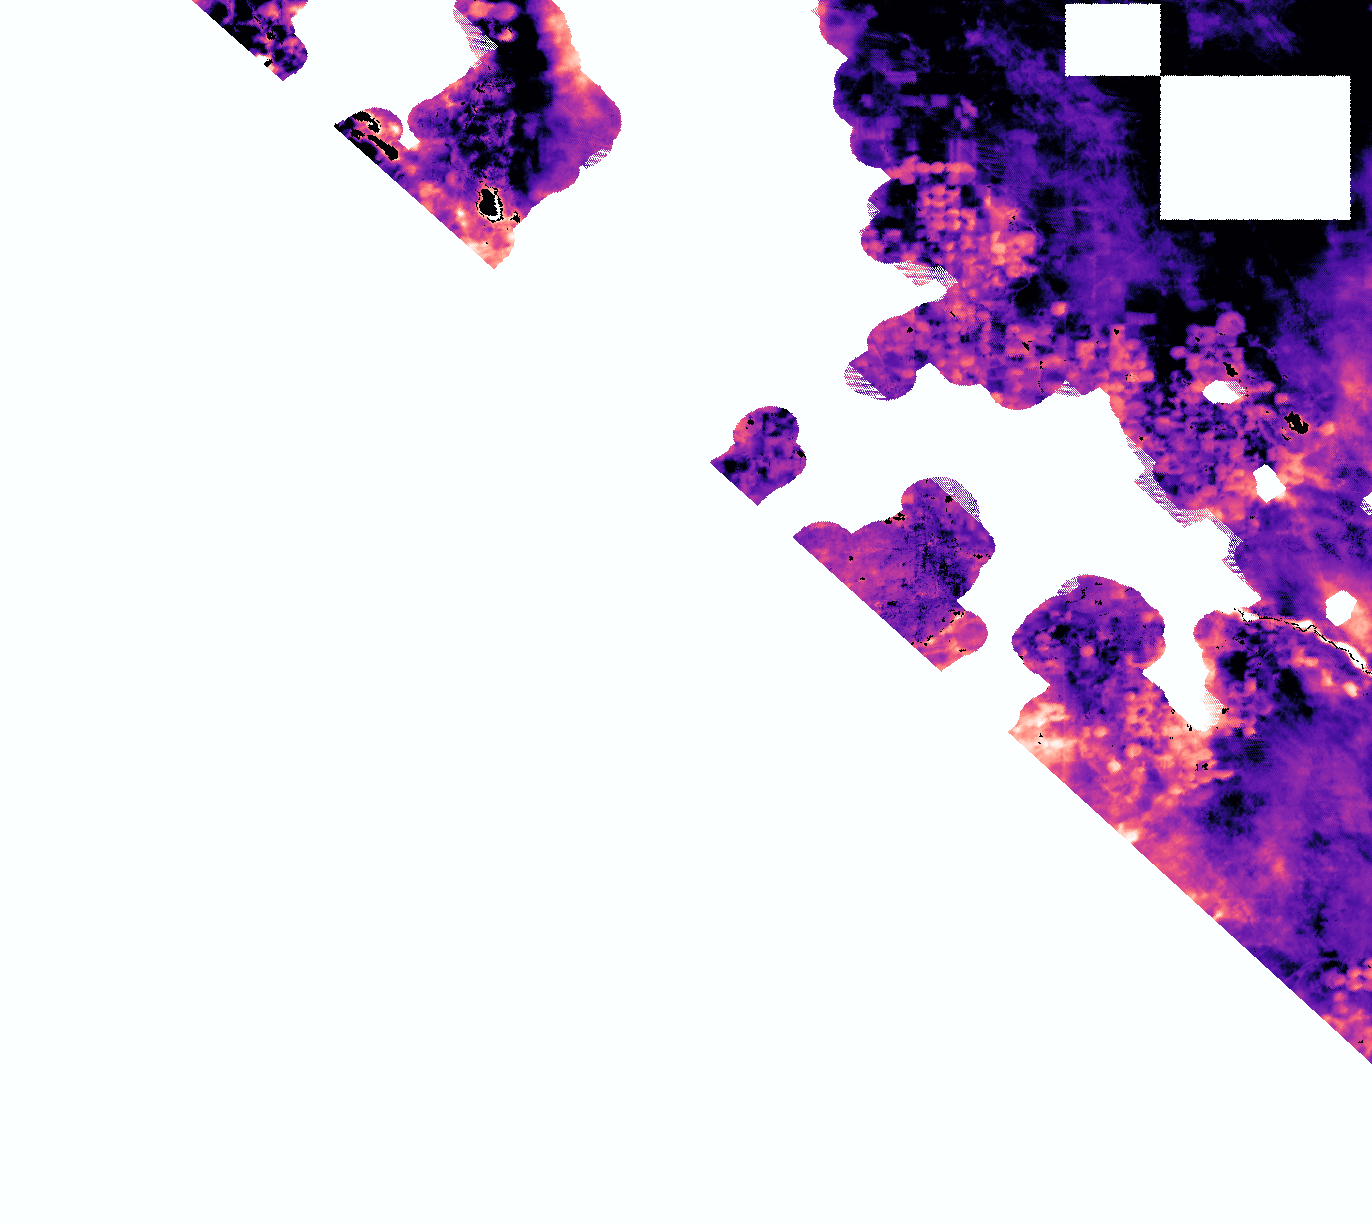
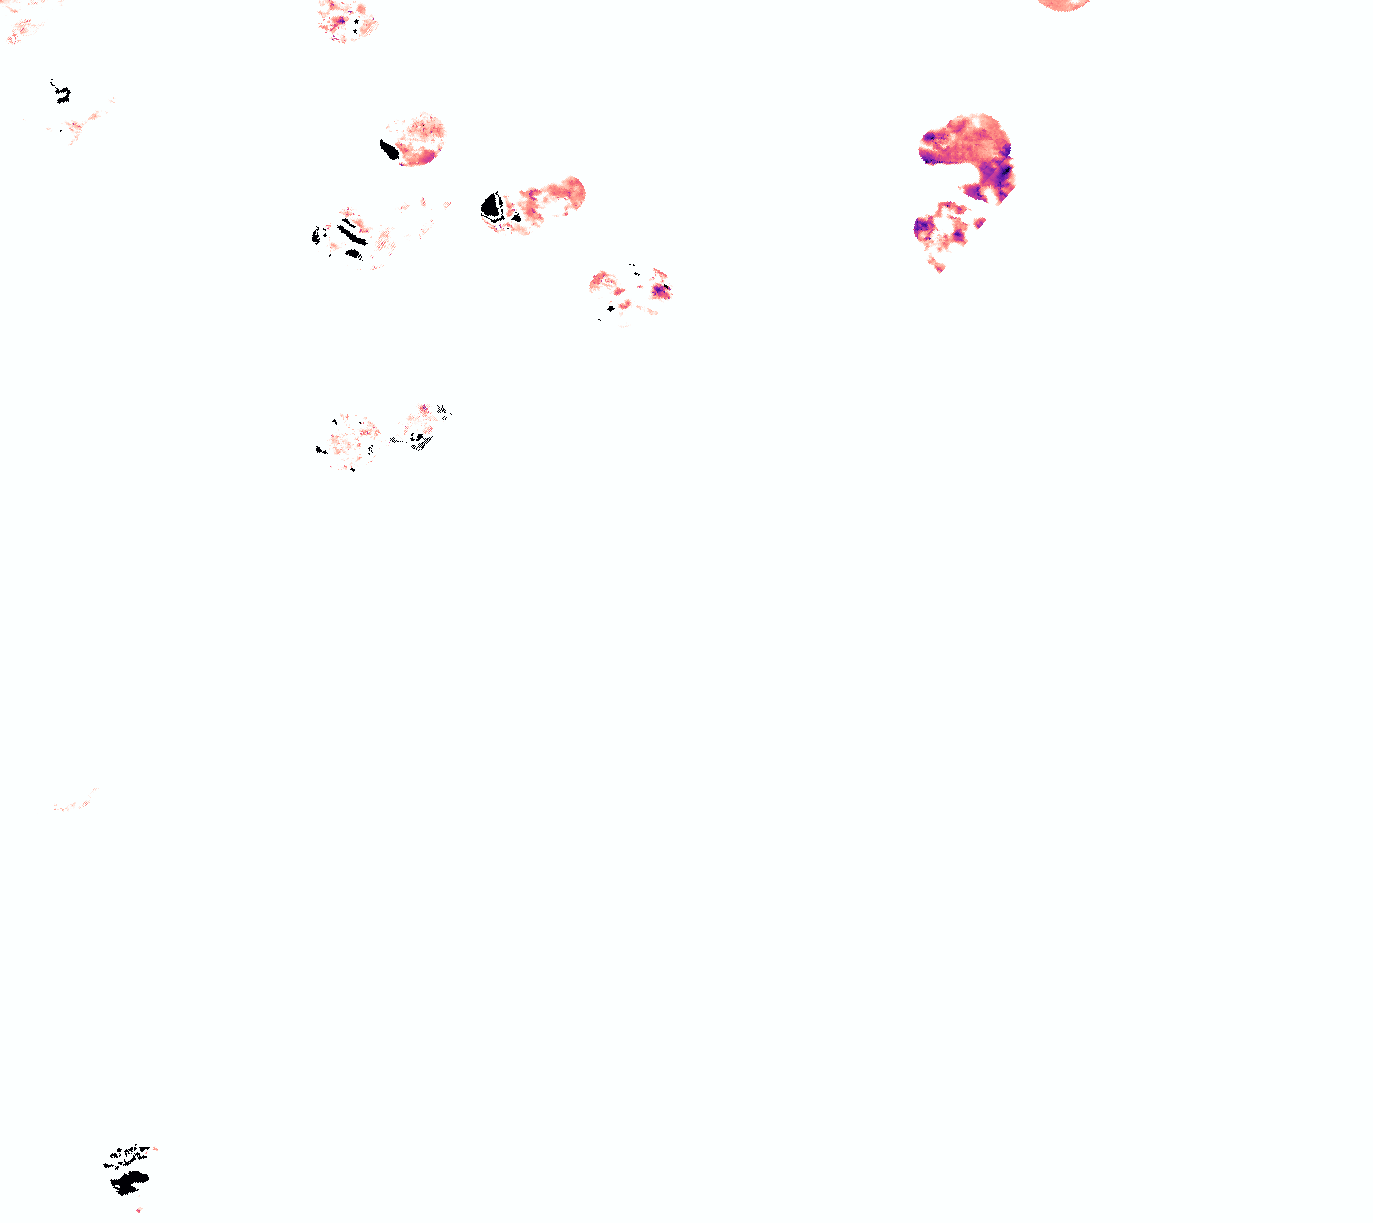

In [46]:
loc=12
infile1 = (f'data/{file_list_2020[loc]}')
infile2 = (f'data/{file_list_2021[loc]}')
plot_dual_map(infile1, infile2)

In [37]:
file_input1 = widgets.Dropdown(
    options=file_list_2020,
    description='Select COG file 1:',
    disabled=False,
)
file_input2 = widgets.Dropdown(
    options=file_list_2021,
    description='Select COG file 2:',
    disabled=False,
)
#file_input1 = widgets.FileUpload(description='Select COG file 1')
#file_input2 = widgets.FileUpload(description='Select COG file 2')
plot_button = widgets.Button(description='Plot')

In [38]:
def on_button_clicked(b):
    if file_input1.value and file_input2.value:
        file1 = f'data/{file_input1.value}'
        file2 = f'data/{file_input2.value}'
        plot_dual_map(file1, file2)

In [39]:
plot_button.on_click(on_button_clicked)

In [40]:
display(widgets.VBox([file_input1, file_input2, plot_button]))

Little bit faster way to visualize the data quick...

In [ ]:
def vis_file(file_loc):
    da = rioxarray.open_rasterio(file_loc, mask_and_scale=True).squeeze('band', drop=True)
    return da.hvplot.image(cmap='plasma')

In [ ]:
vis_file(f'data/{file_list[3]}')

In [ ]:
file_summary = {}
for f in file_list:
    img = f'data/{f}'
    da = rioxarray.open_rasterio(img).squeeze('band', drop=True)
    print(f'{f} -- {da.data.mean()}')

In [ ]:
img1 = f'data/{file_list[1]}'

In [ ]:
da = rioxarray.open_rasterio(img1).squeeze('band', drop=True)
#da

In [ ]:
# boundary of the image on the map
min_lon = float(da.x.min().data)
max_lon = float(da.x.max().data)
min_lat = float(da.y.min().data)
max_lat = float(da.y.max().data)

In [ ]:
import numpy as np
np.unique(da.data)

In [ ]:
map_ = folium.Map(location=[y_center, x_center], zoom_start = 8, tiles='Esri.WorldImagery')

# Overlay the image
folium.raster_layers.ImageOverlay(
    da.data,
    opacity=1,
    bounds =[[min_lat, min_lon], [max_lat, max_lon]],
    colormap='plasma',
    interactive=True).add_to(map_)

map_

In [ ]:
import folium.plugins

In [ ]:
m = folium.plugins.DualMap(location=(y_center, x_center), tiles=None, zoom_start=8)

folium.TileLayer("openstreetmap").add_to(m.m1)
folium.TileLayer("cartodbpositron").add_to(m.m2)

folium.GeoJson(data=roi["geometry"]).add_to(m.m1)
folium.GeoJson(data=roi["geometry"]).add_to(m.m2)

folium.raster_layers.ImageOverlay(image=img1)

folium.LayerControl(collapsed=False).add_to(m)
m

In [ ]:
#f = folium.Figure(width=1000, height=500)    # https://github.com/python-visualization/folium/issues/37
#m = folium.Map(location=[y_center, x_center], zoom_start=7).add_to(f)
